# Credit Risk Resampling Techniques

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
from pathlib import Path
from collections import Counter

In [3]:
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from imblearn.metrics import classification_report_imbalanced

# Read the CSV and Perform Basic Data Cleaning

In [4]:
columns = [
    "loan_amnt", "int_rate", "installment", "home_ownership",
    "annual_inc", "verification_status", "issue_d", "loan_status",
    "pymnt_plan", "dti", "delinq_2yrs", "inq_last_6mths",
    "open_acc", "pub_rec", "revol_bal", "total_acc",
    "initial_list_status", "out_prncp", "out_prncp_inv", "total_pymnt",
    "total_pymnt_inv", "total_rec_prncp", "total_rec_int", "total_rec_late_fee",
    "recoveries", "collection_recovery_fee", "last_pymnt_amnt", "next_pymnt_d",
    "collections_12_mths_ex_med", "policy_code", "application_type", "acc_now_delinq",
    "tot_coll_amt", "tot_cur_bal", "open_acc_6m", "open_act_il",
    "open_il_12m", "open_il_24m", "mths_since_rcnt_il", "total_bal_il",
    "il_util", "open_rv_12m", "open_rv_24m", "max_bal_bc",
    "all_util", "total_rev_hi_lim", "inq_fi", "total_cu_tl",
    "inq_last_12m", "acc_open_past_24mths", "avg_cur_bal", "bc_open_to_buy",
    "bc_util", "chargeoff_within_12_mths", "delinq_amnt", "mo_sin_old_il_acct",
    "mo_sin_old_rev_tl_op", "mo_sin_rcnt_rev_tl_op", "mo_sin_rcnt_tl", "mort_acc",
    "mths_since_recent_bc", "mths_since_recent_inq", "num_accts_ever_120_pd", "num_actv_bc_tl",
    "num_actv_rev_tl", "num_bc_sats", "num_bc_tl", "num_il_tl",
    "num_op_rev_tl", "num_rev_accts", "num_rev_tl_bal_gt_0",
    "num_sats", "num_tl_120dpd_2m", "num_tl_30dpd", "num_tl_90g_dpd_24m",
    "num_tl_op_past_12m", "pct_tl_nvr_dlq", "percent_bc_gt_75", "pub_rec_bankruptcies",
    "tax_liens", "tot_hi_cred_lim", "total_bal_ex_mort", "total_bc_limit",
    "total_il_high_credit_limit", "hardship_flag", "debt_settlement_flag"
]

target = ["loan_status"]

In [5]:
# Load the data
file_path = Path('./LoanStats_2019Q1.csv')
df = pd.read_csv(file_path, skiprows=1)[:-2]
df = df.loc[:, columns].copy()

# Drop the null columns where all values are null
df = df.dropna(axis='columns', how='all')

# Drop the null rows
df = df.dropna()

# Remove the `Issued` loan status
issued_mask = df['loan_status'] != 'Issued'
df = df.loc[issued_mask]

# convert interest rate to numerical
df['int_rate'] = df['int_rate'].str.replace('%', '')
df['int_rate'] = df['int_rate'].astype('float') / 100


# Convert the target column values to low_risk and high_risk based on their values
x = {'Current': 'low_risk'}   
df = df.replace(x)

x = dict.fromkeys(['Late (31-120 days)', 'Late (16-30 days)', 'Default', 'In Grace Period'], 'high_risk')    
df = df.replace(x)

df.reset_index(inplace=True, drop=True)

df.head()

,loan_amnt,int_rate,installment,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,dti,...,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,debt_settlement_flag
0,10500.0,0.1719,375.35,RENT,66000.0,Source Verified,Mar-2019,low_risk,n,27.24,...,85.7,100.0,0.0,0.0,65687.0,38199.0,2000.0,61987.0,N,N
1,25000.0,0.2000,929.09,MORTGAGE,105000.0,Verified,Mar-2019,low_risk,n,20.23,...,91.2,50.0,1.0,0.0,271427.0,60641.0,41200.0,49197.0,N,N
2,20000.0,0.2000,529.88,MORTGAGE,56000.0,Verified,Mar-2019,low_risk,n,24.26,...,66.7,50.0,0.0,0.0,60644.0,45684.0,7500.0,43144.0,N,N
3,10000.0,0.1640,353.55,RENT,92000.0,Verified,Mar-2019,low_risk,n,31.44,...,100.0,50.0,1.0,0.0,99506.0,68784.0,19700.0,76506.0,N,N
4,22000.0,0.1474,520.39,MORTGAGE,52000.0,Not Verified,Mar-2019,low_risk,n,18.76,...,100.0,0.0,0.0,0.0,219750.0,25919.0,27600.0,20000.0,N,N


# Split the Data into Training and Testing

In [6]:
# Create our features
X = df.drop(columns=['loan_status'], axis=1)
X = pd.get_dummies(X)

# Create our target
y = df['loan_status']

In [7]:
X.columns

Index(['loan_amnt', 'int_rate', 'installment', 'annual_inc', 'dti',
       'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal',
       'total_acc', 'out_prncp', 'out_prncp_inv', 'total_pymnt',
       'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
       'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
       'last_pymnt_amnt', 'collections_12_mths_ex_med', 'policy_code',
       'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'open_acc_6m',
       'open_act_il', 'open_il_12m', 'open_il_24m', 'mths_since_rcnt_il',
       'total_bal_il', 'il_util', 'open_rv_12m', 'open_rv_24m', 'max_bal_bc',
       'all_util', 'total_rev_hi_lim', 'inq_fi', 'total_cu_tl', 'inq_last_12m',
       'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util',
       'chargeoff_within_12_mths', 'delinq_amnt', 'mo_sin_old_il_acct',
       'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl',
       'mort_acc', 'mths_since_recent_bc', 'mths_since_recent_in

In [8]:
X.describe()

,loan_amnt,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,...,issue_d_Mar-2019,pymnt_plan_n,initial_list_status_f,initial_list_status_w,next_pymnt_d_Apr-2019,next_pymnt_d_May-2019,application_type_Individual,application_type_Joint App,hardship_flag_N,debt_settlement_flag_N
count,68817.000000,68817.000000,68817.000000,6.881700e+04,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,...,68817.000000,68817.0,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.0,68817.0
mean,16677.594562,0.127718,480.652863,8.821371e+04,21.778153,0.217766,0.497697,12.587340,0.126030,17604.142828,...,0.177238,1.0,0.123879,0.876121,0.383161,0.616839,0.860340,0.139660,1.0,1.0
std,10277.348590,0.048130,288.062432,1.155800e+05,20.199244,0.718367,0.758122,6.022869,0.336797,21835.880400,...,0.381873,0.0,0.329446,0.329446,0.486161,0.486161,0.346637,0.346637,0.0,0.0
min,1000.000000,0.060000,30.890000,4.000000e+01,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,...,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,1.0
25%,9000.000000,0.088100,265.730000,5.000000e+04,13.890000,0.000000,0.000000,8.000000,0.000000,6293.000000,...,0.000000,1.0,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.0,1.0
50%,15000.000000,0.118000,404.560000,7.300000e+04,19.760000,0.000000,0.000000,11.000000,0.000000,12068.000000,...,0.000000,1.0,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.0,1.0
75%,24000.000000,0.155700,648.100000,1.040000e+05,26.660000,0.000000,1.000000,16.000000,0.000000,21735.000000,...,0.000000,1.0,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.0,1.0
max,40000.000000,0.308400,1676.230000,8.797500e+06,999.000000,18.000000,5.000000,72.000000,4.000000,587191.000000,...,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0


In [9]:
# Check the balance of our target values
y.value_counts()

low_risk     68470
high_risk      347
Name: loan_status, dtype: int64

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, stratify=y)
Counter(y_train)

Counter({'low_risk': 51352, 'high_risk': 260})

# Oversampling

In this section, you will compare two oversampling algorithms to determine which algorithm results in the best performance. You will oversample the data using the naive random oversampling algorithm and the SMOTE algorithm. For each algorithm, be sure to complete the folliowing steps:

1. View the count of the target classes using `Counter` from the collections library. 
3. Use the resampled data to train a logistic regression model.
3. Calculate the balanced accuracy score from sklearn.metrics.
4. Print the confusion matrix from sklearn.metrics.
5. Generate a classication report using the `imbalanced_classification_report` from imbalanced-learn.

Note: Use a random state of 1 for each sampling algorithm to ensure consistency between tests

### Naive Random Oversampling

In [11]:
# implement random oversampling
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=1)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)
Counter(y_resampled)

Counter({'low_risk': 51352, 'high_risk': 51352})

In [12]:
# Train the Logistic Regression model using the resampled data
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(solver='lbfgs', random_state=1)
model = model.fit(X_resampled, y_resampled)

In [13]:
# Calculated the balanced accuracy score
from sklearn.metrics import balanced_accuracy_score
y_pred = model.predict(X_test)
acc_score=balanced_accuracy_score(y_test, y_pred)

In [14]:
# Display the confusion matrix
from sklearn.metrics import confusion_matrix

y_pred = model.predict(X_test)
cm= confusion_matrix(y_test, y_pred)
# Create df for confusion matrix
cm_df = pd.DataFrame(
    cm, index=["Actual High Risk", "Actual Low Risk"], columns=["Predicted High Risk", "Predicted Low Risk"])

cm_df

,Predicted High Risk,Predicted Low Risk
Actual High Risk,52,35
Actual Low Risk,5952,11166


In [15]:
# Print the imbalanced classification report
from imblearn.metrics import classification_report_imbalanced

# Displaying results
print("RandomOverSampler")
print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score : {acc_score}")
print("classification_report_imbalanced")
print(classification_report_imbalanced(y_test, y_pred))

RandomOverSampler
Confusion Matrix


,Predicted High Risk,Predicted Low Risk
Actual High Risk,52,35
Actual Low Risk,5952,11166


Accuracy Score : 0.6249984891886339
classification_report_imbalanced
                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.01      0.60      0.65      0.02      0.62      0.39        87
   low_risk       1.00      0.65      0.60      0.79      0.62      0.39     17118

avg / total       0.99      0.65      0.60      0.78      0.62      0.39     17205



### SMOTE Oversampling

In [16]:
# Resample the training data with SMOTE
from imblearn.over_sampling import SMOTE
X_resampled, y_resampled = SMOTE(random_state=1, sampling_strategy='auto').fit_resample(
    X_train, y_train
)
Counter(y_resampled)

Counter({'low_risk': 51352, 'high_risk': 51352})

In [17]:
# Train the Logistic Regression model using the resampled data
model = LogisticRegression(solver='lbfgs', random_state=1)
model = model.fit(X_resampled, y_resampled)

In [18]:
# Calculated the balanced accuracy score
y_pred = model.predict(X_test)
acc_score = balanced_accuracy_score(y_test, y_pred)

In [19]:
# Display the confusion matrix
cm= confusion_matrix(y_test, y_pred)
# Create df for confusion matrix
cm_df = pd.DataFrame(
    cm, index=["Actual High Risk", "Actual Low Risk"], columns=["Predicted High Risk", "Predicted Low Risk"])

cm_df

,Predicted High Risk,Predicted Low Risk
Actual High Risk,56,31
Actual Low Risk,5840,11278


In [20]:
# Print the imbalanced classification report
# Displaying results
print("SMOTE")
print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score : {acc_score}")
print("classification_report_imbalanced")
print(classification_report_imbalanced(y_test, y_pred))

SMOTE
Confusion Matrix


,Predicted High Risk,Predicted Low Risk
Actual High Risk,56,31
Actual Low Risk,5840,11278


Accuracy Score : 0.6512584051472337
classification_report_imbalanced
                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.01      0.64      0.66      0.02      0.65      0.42        87
   low_risk       1.00      0.66      0.64      0.79      0.65      0.42     17118

avg / total       0.99      0.66      0.64      0.79      0.65      0.42     17205



# Undersampling

In this section, you will test an undersampling algorithms to determine which algorithm results in the best performance compared to the oversampling algorithms above. You will undersample the data using the Cluster Centroids algorithm and complete the folliowing steps:

1. View the count of the target classes using `Counter` from the collections library. 
3. Use the resampled data to train a logistic regression model.
3. Calculate the balanced accuracy score from sklearn.metrics.
4. Print the confusion matrix from sklearn.metrics.
5. Generate a classication report using the `imbalanced_classification_report` from imbalanced-learn.

Note: Use a random state of 1 for each sampling algorithm to ensure consistency between tests

In [21]:
# Resample the data using the ClusterCentroids resampler
from imblearn.under_sampling import ClusterCentroids
cc = ClusterCentroids(random_state=1)
X_resampled, y_resampled = cc.fit_resample(X_train, y_train)

In [22]:
# Train the Logistic Regression model using the resampled data
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(solver='lbfgs', random_state=1)
model.fit(X_resampled, y_resampled)

LogisticRegression(random_state=1)

In [23]:
# Calculated the balanced accuracy score
from sklearn.metrics import balanced_accuracy_score
acc_score = balanced_accuracy_score(y_test, y_pred)

In [24]:
# Display the confusion matrix
from sklearn.metrics import confusion_matrix
y_pred = model.predict(X_test)
cm= confusion_matrix(y_test, y_pred)
# Create df for confusion matrix
cm_df = pd.DataFrame(
    cm, index=["Actual High Risk", "Actual Low Risk"], columns=["Predicted High Risk", "Predicted Low Risk"])

cm_df

,Predicted High Risk,Predicted Low Risk
Actual High Risk,51,36
Actual Low Risk,9682,7436


In [25]:
# Print the imbalanced classification report
from imblearn.metrics import classification_report_imbalanced
print("ClusterCentroids")
print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score : {acc_score}")
print("classification_report_imbalanced")
print(classification_report_imbalanced(y_test, y_pred))

ClusterCentroids
Confusion Matrix


,Predicted High Risk,Predicted Low Risk
Actual High Risk,51,36
Actual Low Risk,9682,7436


Accuracy Score : 0.6512584051472337
classification_report_imbalanced
                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.01      0.59      0.43      0.01      0.50      0.26        87
   low_risk       1.00      0.43      0.59      0.60      0.50      0.25     17118

avg / total       0.99      0.44      0.59      0.60      0.50      0.25     17205



# Combination (Over and Under) Sampling

In this section, you will test a combination over- and under-sampling algorithm to determine if the algorithm results in the best performance compared to the other sampling algorithms above. You will resample the data using the SMOTEENN algorithm and complete the folliowing steps:

1. View the count of the target classes using `Counter` from the collections library. 
3. Use the resampled data to train a logistic regression model.
3. Calculate the balanced accuracy score from sklearn.metrics.
4. Print the confusion matrix from sklearn.metrics.
5. Generate a classication report using the `imbalanced_classification_report` from imbalanced-learn.

Note: Use a random state of 1 for each sampling algorithm to ensure consistency between tests

In [26]:
# Resample the training data with SMOTEENN
# Warning: This is a large dataset, and this step may take some time to complete
from imblearn.combine import SMOTEENN

smote_enn = SMOTEENN(random_state=0)
X_resampled, y_resampled = smote_enn.fit_resample(X, y)
Counter(y_resampled)

Counter({'high_risk': 68460, 'low_risk': 62011})

In [27]:
# Train the Logistic Regression model using the resampled data
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(solver='lbfgs', random_state=1)
model.fit(X_resampled, y_resampled)

LogisticRegression(random_state=1)

In [28]:
# Calculated the balanced accuracy score
from sklearn.metrics import balanced_accuracy_score

bacc_score = balanced_accuracy_score(y_test, y_pred)
balanced_accuracy_score(y_test, y_pred)

0.5103017191018931

In [29]:
# Display the confusion matrix
from sklearn.metrics import confusion_matrix

y_pred = model.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[  61,   26],
       [7294, 9824]], dtype=int64)

In [30]:
# Display the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create df for confusion matrix
cm_df = pd.DataFrame(
    cm, index=["Actual High Risk", "Actual Low Risk"], columns=["Predicted High Risk", "Predicted Low Risk"])

cm_df

,Predicted High Risk,Predicted Low Risk
Actual High Risk,61,26
Actual Low Risk,7294,9824


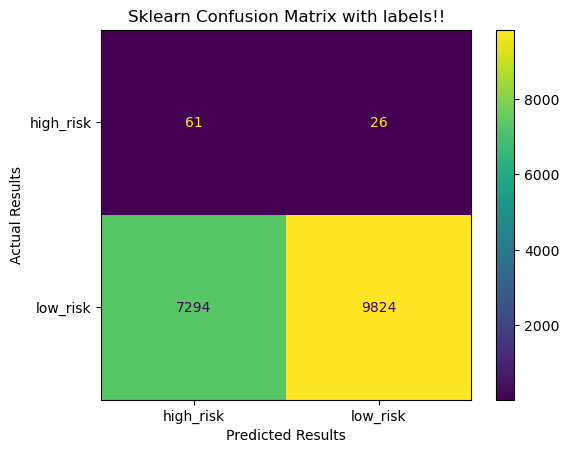

In [31]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)
cmd_obj = ConfusionMatrixDisplay(cm, display_labels=['high_risk', 'low_risk'])
cmd_obj.plot()
cmd_obj.ax_.set(
                title='Sklearn Confusion Matrix with labels!!', 
                xlabel='Predicted Results', 
                ylabel='Actual Results')
plt.show()

In [32]:
# Print the imbalanced classification report
from imblearn.metrics import classification_report_imbalanced
print("SMOTEENN")
print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score : {bacc_score}")
print("classification_report_imbalanced")
print(classification_report_imbalanced(y_test, y_pred))

SMOTEENN
Confusion Matrix


,Predicted High Risk,Predicted Low Risk
Actual High Risk,61,26
Actual Low Risk,7294,9824


Accuracy Score : 0.5103017191018931
classification_report_imbalanced
                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.01      0.70      0.57      0.02      0.63      0.41        87
   low_risk       1.00      0.57      0.70      0.73      0.63      0.40     17118

avg / total       0.99      0.57      0.70      0.72      0.63      0.40     17205

